# Bildauflösung reduzieren

Dieses Notebook zeigt, wie man die **räumliche Auflösung** eines RGB-Bildes reduziert,
z.B. von 10 m/Pixel auf 20 m/Pixel, indem man die Pixel mit einem **Skalierungsfaktor** "runterrechnet".

**Idee:**
- Ein Faktor von `2` bedeutet: aus jeweils 2×2 Pixeln wird **ein** Pixel gemacht.
- Die neuen Pixelwerte werden als **Mittelwert** der ursprünglichen Pixel im Block berechnet.

## 1. Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
import requests

## 2. Hilfsfunktion: Bild von URL laden

In [14]:
def load_image_from_url(url):
    """Lädt ein Bild von einer URL und gibt ein PIL-Image im RGB-Format
    sowie das zugehörige NumPy-Array zurück."""
    response = requests.get(url)
    response.raise_for_status()
    img = Image.open(BytesIO(response.content)).convert("RGB")
    return img, np.array(img)


## 3. Funktion: Auflösung reduzieren
Die Funktion `reduce_resolution` nimmt ein RGB-Bild als NumPy-Array und einen **ganzzahligen Faktor**.
- `factor = 2` → Auflösung halbiert (z.B. 10 m → 20 m pro Pixel)
- `method = 'average'` → Block-Mittelwerte (empfohlen)

In [15]:
def reduce_resolution(img_arr, factor=2):
    """Reduziert die räumliche Auflösung eines RGB-Bildes um einen ganzzahligen Faktor.

    Parameter
    ---------
    img_arr : np.ndarray
        Bild als NumPy-Array der Form (H, W, 3) im RGB-Format.
    factor : int
        Vergröberungsfaktor (z.B. 2, 3, 4...).
    method : str
        "average"   -> Block-Mittelwert (empfohlen)
        "subsample" -> nimmt nur jeden factor-ten Pixel.
    """
    if img_arr.ndim != 3 or img_arr.shape[2] != 3:
        raise ValueError("img_arr muss die Form (H, W, 3) haben (RGB-Bild).")
    if factor < 1 or not isinstance(factor, int):
        raise ValueError("factor muss eine ganze Zahl >= 1 sein.")

    H, W, C = img_arr.shape

    # Bildgröße auf ein Vielfaches von factor zuschneiden
    H_new = (H // factor) * factor
    W_new = (W // factor) * factor
    trimmed = img_arr[:H_new, :W_new, :]

    # In Blöcke der Größe factor x factor zerlegen und den Mittelwert berechnen
    h_blocks = H_new // factor
    w_blocks = W_new // factor

    reshaped = trimmed.reshape(h_blocks, factor, w_blocks, factor, C)
    downsampled = reshaped.mean(axis=(1, 3))

    return downsampled.astype(np.uint8)

    raise ValueError("Unbekannte method: benutze 'average' oder 'subsample'.")


## 4. Parameter setzen
Hier kannst du:
- eine Bild-URL angeben (z.B. Luftbild, Orthofoto, Satellitenbild),
- die ursprüngliche Bodenauflösung (Meter pro Pixel) setzen,
- den Faktor für die Vergröberung einstellen.

In [16]:
IMAGE_URL = "https://www.berlin.de/sen/sbw/_assets/stadtdaten/geoportal/landesvermessung/tierheim_800.jpg"

original_resolution_m = 20
factor = 10

print("Aktuelle IMAGE_URL:", IMAGE_URL)
print("Ursprüngliche Auflösung (m/Pixel):", original_resolution_m)
print("Faktor:", factor)


Aktuelle IMAGE_URL: https://www.berlin.de/sen/sbw/_assets/stadtdaten/geoportal/landesvermessung/tierheim_800.jpg
Ursprüngliche Auflösung (m/Pixel): 20
Faktor: 10


## 5. Bild laden und Original anzeigen

Originalbild-Form (H, W, C): (802, 800, 3)


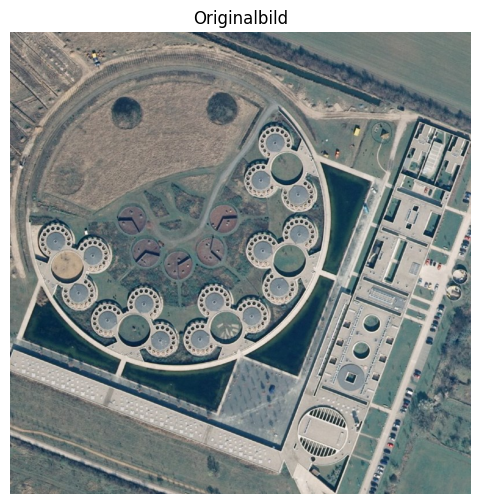

In [17]:
img_pil, img_arr = load_image_from_url(IMAGE_URL)
print("Originalbild-Form (H, W, C):", img_arr.shape)

plt.figure(figsize=(6, 6))
plt.imshow(img_arr)
plt.title("Originalbild")
plt.axis("off")
plt.show()


## 6. Auflösung reduzieren und Resultate vergleichen

Vergröbertes Bild - Form (H, W, C): (80, 80, 3)
Neue Auflösung: 200 m/Pixel


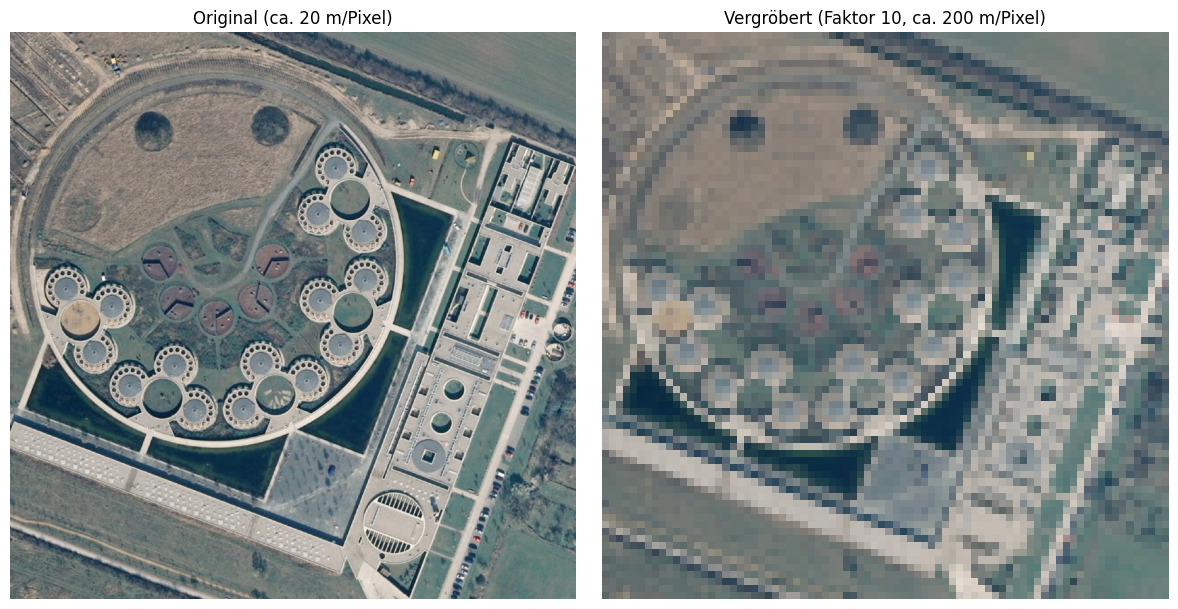

In [18]:
new_resolution_m = original_resolution_m * factor

# Auflösung reduzieren (Block-Mittelwert)
img_down = reduce_resolution(img_arr, factor=factor)

print("Vergröbertes Bild - Form (H, W, C):", img_down.shape)
print(f"Neue Auflösung: {new_resolution_m} m/Pixel")

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(img_arr)
axes[0].set_title(f"Original (ca. {original_resolution_m} m/Pixel)")
axes[0].axis("off")

axes[1].imshow(img_down)
axes[1].set_title(f"Vergröbert (Faktor {factor}, ca. {new_resolution_m} m/Pixel)")
axes[1].axis("off")

plt.tight_layout()
plt.show()
